In [86]:
from PIL import Image
from glob import glob
import cv2

path_to_img = "greyscale"
path_to_seg = "greyscale_out"

images = sorted(glob(os.path.join(path_to_img, "IMG*.tiff")))
segs = sorted(glob(os.path.join(path_to_seg, "I0*.tiff")))

img = Image.open(images[0]).convert('L')
img.save("greyscale\\new.png")

a = cv2.imread(images[0],0)
#gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
#cv2.imwrite("test_opencv.tiff",gray)

#b = cv2.imread("test_opencv.tiff",0)#,cv2.CV_LOAD_IMAGE_GRAYSCALE)
#b.shape
a.shape

(736, 736)

In [87]:
#from scipy.misc import imread
#image2 = imread(images[0])
#print (image2.shape)

#img = Image.open(images[0])

#print(img.mode)


In [88]:
#Convert all images to greyscale
from glob import glob
import cv2
import ntpath

ntpath.basename("a/b/c") #https://stackoverflow.com/questions/8384737/extract-file-name-from-path-no-matter-what-the-os-path-format
def path_leaf(path): #extract filename from path
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

path_to_img = "greyscale"
path_to_seg = "greyscale_out"



images = sorted(glob(os.path.join(path_to_img, "IMG*.tiff")))
segs = sorted(glob(os.path.join(path_to_seg, "I0*.tiff")))

#
#for i in range(len(images)):
#  a = cv2.imread(images[i])
#  grey = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
#  file = path_leaf(images[i])
#  cv2.imwrite(("greyscale\\" + file),grey)

for i in range(len(segs)):
  a = cv2.imread(segs[i])
  grey = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
  file = path_leaf(segs[i])
  cv2.imwrite(("greyscale_out\\" + file),grey)

In [89]:
import ntpath
ntpath.basename("a/b/c")
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)


print(path_leaf("greyscale\\" + images[1]))


IMG00000_02.tiff


In [90]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import tempfile
from glob import glob
from natsort import natsorted
import random

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityd,
    EnsureTyped,
    EnsureType,
    RandGaussianNoised
)
from monai.visualize import plot_2d_or_3d_image



monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

path_to_grey_img = r"greyscale"
path_to_grey_seg = r"greyscale_out"

images = natsorted(glob(os.path.join(path_to_grey_img, "IMG*.tiff")))
segs = natsorted(glob(os.path.join(path_to_grey_seg, "I0*.tiff")))

val_samples = 10
random.seed(1234)
val_idx = random.sample(range(0,len(segs)),val_samples)
train_idx = [id for id in range(0,len(segs))]
train_idx = [id for id in train_idx if id not in val_idx]

train_images = [images[idx] for idx in train_idx]
masks = [segs[idx] for idx in train_idx] 
val_images = [images[idx] for idx in val_idx]
val_masks =   [segs[idx] for idx in val_idx]

train_files = [{"img": img, "seg": seg}
                for img, seg in zip(train_images, masks)]
val_files = [{"img": img, "seg": seg}
                for img, seg in zip(val_images, val_masks)]

# define transforms for image and segmentation
train_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        AddChanneld(keys=["img", "seg"]),
        ScaleIntensityd(keys=["img", "seg"]),
        RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 1]),
        RandGaussianNoised(keys=["img"], prob = 0.1, mean = 0, std = 0.1),
        EnsureTyped(keys=["img", "seg"]),  
    ]
)
#RandCropByPosNegLabeld(
#            keys=["img", "seg"], label_key="seg", spatial_size=[192, 192], pos=1, neg=1, num_samples=4
#        ), #REMOVAL?


val_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        AddChanneld(keys=["img", "seg"]),
        ScaleIntensityd(keys=["img", "seg"]),
        EnsureTyped(keys=["img", "seg"]),
    ]
)

MONAI version: 0.8.0
Numpy version: 1.19.3
Pytorch version: 1.10.2+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.2
scikit-image version: 0.19.1
Pillow version: 9.0.1
Tensorboard version: 2.5.0
gdown version: 4.2.1
TorchVision version: 0.11.3+cpu
tqdm version: 4.58.0
lmdb version: 1.3.0
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [91]:

def main(tempdir):
    # define dataset, data loader
    check_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
    # use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
    check_loader = DataLoader(check_ds, batch_size=2,
                              num_workers=4, collate_fn=list_data_collate)
    #check_data = monai.utils.misc.first(check_loader)
    #print(check_data["img"].shape, check_data["seg"].shape)

    # create a training data loader
    train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
    # use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
    train_loader = DataLoader(
        train_ds,
        batch_size=2,
        shuffle=True,
        num_workers=4,
        collate_fn=list_data_collate,
        pin_memory=torch.cuda.is_available(),
    )
    # create a validation data loader
    val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=1,
                            num_workers=4, collate_fn=list_data_collate)
    dice_metric = DiceMetric(include_background=False,
                             reduction="mean", get_not_nans=False)
    post_trans = Compose([EnsureType(), Activations(
        sigmoid=True), AsDiscrete(threshold=0.5)])
    # create UNet, DiceLoss and Adam optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)
    loss_function = monai.losses.DiceLoss(smooth_nr = 0, smooth_dr = 1e-5, sigmoid = True)
    #optimizer = torch.optim.Adam(model.parameters(), 1e-2)
    #optimizer = monai.optimizers.Novograd(model.parameters(), 1e-3)
    optimizer = torch.optim.SGD(model.parameters(),1e-3, momentum = 0.99)

    # start a typical PyTorch training
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    metric_values = list()
    writer = SummaryWriter()
    for epoch in range(300):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{300}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data["img"].to(
                device), batch_data["seg"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(),
                              epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                for val_data in val_loader:
                    val_images, val_labels = val_data["img"].to(
                        device), val_data["seg"].to(device)
                    #roi_size = (192, 192)
                    #val_outputs = sliding_window_inference(
                        #val_images, roi_size, sw_batch_size, model)
                    sw_batch_size = 4
                    output = model(val_images)
                    val_outputs = [post_trans(i) for i in decollate_batch(output)]
                    #val_outputs = [post_trans(i)
                                   #for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)
                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(),
                               "best_metric_model_segmentation2d_dict.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_mean_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                plot_2d_or_3d_image(val_images, epoch + 1,
                                    writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1,
                                    writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs, epoch + 1,
                                    writer, index=0, tag="output")

    print(
        f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()


if __name__ == "__main__":
    with tempfile.TemporaryDirectory() as tempdir:
        main(tempdir)


----------
epoch 1/300
1/16, train_loss: 0.9128
2/16, train_loss: 0.9290
3/16, train_loss: 0.9277
4/16, train_loss: 0.9286
5/16, train_loss: 0.9417
6/16, train_loss: 0.9399
7/16, train_loss: 0.8973
8/16, train_loss: 0.9246
9/16, train_loss: 0.8925
10/16, train_loss: 0.9136
11/16, train_loss: 0.9009
12/16, train_loss: 0.9338
13/16, train_loss: 0.9363
14/16, train_loss: 0.9059
15/16, train_loss: 0.8967
16/16, train_loss: 0.9462
epoch 1 average loss: 0.9205
----------
epoch 2/300
1/16, train_loss: 0.9504
2/16, train_loss: 0.9019
3/16, train_loss: 0.9029
4/16, train_loss: 0.8967
5/16, train_loss: 0.9262
6/16, train_loss: 0.8802
7/16, train_loss: 0.9526
8/16, train_loss: 0.9259
9/16, train_loss: 0.9172
10/16, train_loss: 0.8964
11/16, train_loss: 0.9256
12/16, train_loss: 0.8919
13/16, train_loss: 0.8950
14/16, train_loss: 0.9536
15/16, train_loss: 0.9300


KeyboardInterrupt: 

In [ ]:
import cv2
from glob import glob
path_to_grey_img = r"greyscale"

images = sorted(glob(os.path.join(path_to_grey_img, "IMG*.tiff")))

a = cv2.imread(images[0])
a.shape


(736, 736, 3)

In [ ]:
import cv2
from glob import glob
path_to_img = "greyscale"
path_to_seg = "greyscale_out"

images = sorted(glob(os.path.join(path_to_img, "IMG*.tiff")))

a = cv2.imread(images[0])
grey = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
grey.shape


for i in grey:
  
  print(i)




[153 162 163 169 176 182 188 193 194 193 202 202 210 213 212 216 206 210
 202 199 194 187 192 180 178 171 172 179 176 174 172 174 170 174 176 171
 167 164 169 166 162 169 162 171 167 165 166 163 166 159 167 162 163 162
 163 164 161 162 153 152 152 146 144 130 131 124 113 108  99  95  95  92
  91  85  83  83  86  88  94  99  98 104 103 103 105 102 100  98 101  95
  98 105 103 102 101 102  98 101 103 107 106 107 104  99 104 102  97  96
 100 101  95  88  83  89  90  85  85  81  79  76  73  77  81  82  75  77
  81  85  76  77  79  81  87  83  85  77  79  78  79  86  81  81  81  79
  79  84  84  82  81  85  86  85  82  84  87  91  88  89  93  91  91  90
  83  79  78  73  71  79  83  77  73  72  75  71  71  74  69  74  69  72
  70  72  77  81  72  70  73  69  69  74  68  68  70  78  81  69  64  69
  83  78  76  73  79  81  87  87  86  93  93  96  94  87  93  96  88  95
  93  92  84  87  88  93  89  87  84  76  78  81  84  86  87  87  79  84
  76  75  77  79  79  74  78  81  70  74  75  79  7

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.data import DataLoader
from natsort import natsorted

import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import Activations, AddChanneld, AsDiscrete, Compose, LoadImaged, SaveImage, ScaleIntensityd, EnsureTyped, EnsureType


def main(tempdir):
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    path_to_grey_img = r"greyscale"
    path_to_grey_seg = r"greyscale_out"

    #images = natsorted(glob(os.path.join(path_to_grey_img, "IMG*.tiff")))
    #segs = natsorted(glob(os.path.join(path_to_grey_seg, "I0*.tiff")))

    #val_files = [{"img": img, "seg": seg} for img, seg in zip(images, segs)]

    # define transforms for image and segmentation
    val_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            AddChanneld(keys=["img", "seg"]),
            ScaleIntensityd(keys=["img", "seg"]),
            EnsureTyped(keys=["img", "seg"]),
        ]
    )
    val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
    # sliding window inference need to input 1 image in every iteration
    val_loader = DataLoader(val_ds, batch_size=1,
                            num_workers=4, collate_fn=list_data_collate)
    dice_metric = DiceMetric(include_background=False,
                             reduction="mean", get_not_nans=False)
    post_trans = Compose([EnsureType(), Activations(
        sigmoid=True), AsDiscrete(threshold=0.5)])
    saver = SaveImage(output_dir="./output",
                      output_ext=".png", output_postfix="seg")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    model.load_state_dict(torch.load(
        "best_metric_model_segmentation2d_dict.pth"))

    model.eval()
    with torch.no_grad():
        for val_data in val_loader:
            val_images, val_labels = val_data["img"].to(
                device), val_data["seg"].to(device)
            # define sliding window size and batch size for windows inference
            #roi_size = (192, 192)
            sw_batch_size = 4
            val_output = model(val_images)
            #val_outputs = sliding_window_inference(
                #val_images, roi_size, sw_batch_size, model)
            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            val_labels = decollate_batch(val_labels)
            # compute metric for current iteration
            dice_metric(y_pred=val_outputs, y=val_labels)
            for val_output in val_outputs:
                saver(val_output)
        # aggregate the final mean dice result
        print("evaluation metric:", dice_metric.aggregate().item())
        # reset the status
        dice_metric.reset()


if __name__ == "__main__":
    with tempfile.TemporaryDirectory() as tempdir:
        main(tempdir)


MONAI version: 0.8.0
Numpy version: 1.19.3
Pytorch version: 1.10.2+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.2
scikit-image version: 0.19.1
Pillow version: 9.0.1
Tensorboard version: 2.5.0
gdown version: 4.2.1
TorchVision version: 0.11.3+cpu
tqdm version: 4.58.0
lmdb version: 1.3.0
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

file written: c:\Users\EmilR\Documents\Datalogi\bachelor\temp\output\0\0_seg.png.
file written: c:\Users\EmilR\Documents\Datalogi\bachelor\temp\output\1\1_seg.png.
file written: c:\Users\EmilR\Documents\Datalogi\bachelor\temp\output\2\2

['greyscale\\IMG00000_01.tiff', 'greyscale\\IMG00000_02.tiff', 'greyscale\\IMG00000_03.tiff', 'greyscale\\IMG00000_04.tiff']
['greyscale_out\\I0_01.tiff', 'greyscale_out\\I0_02.tiff', 'greyscale_out\\I0_03.tiff', 'greyscale_out\\I0_04.tiff']


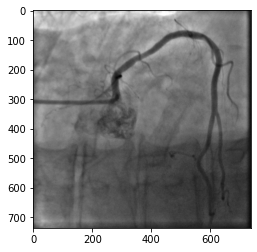

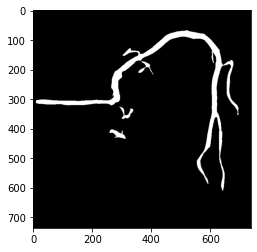

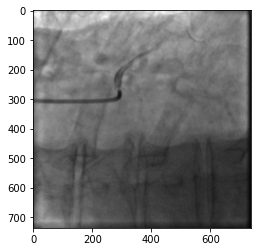

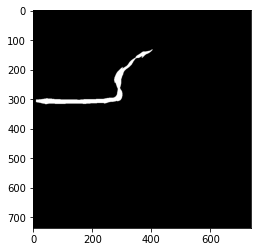

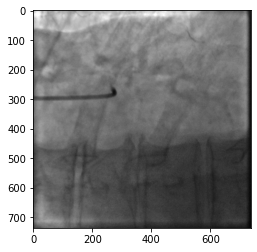

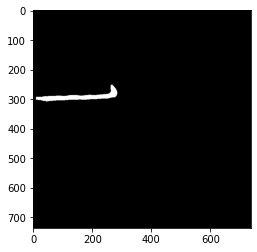

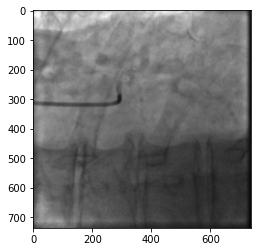

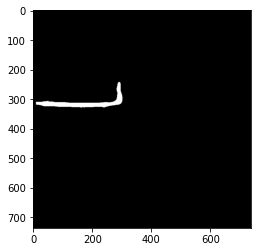

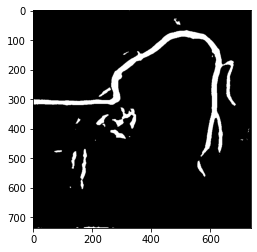

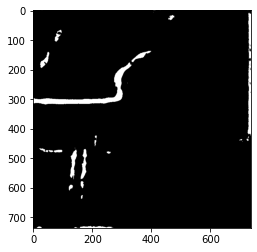

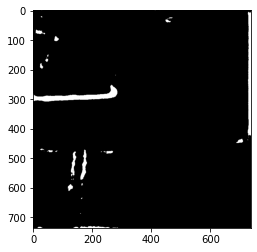

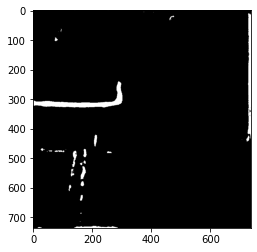

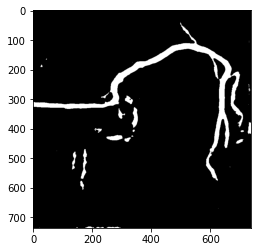

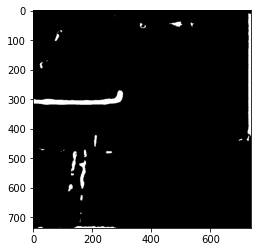

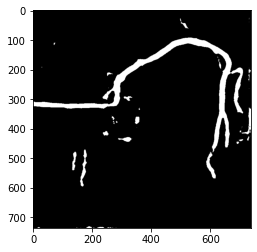

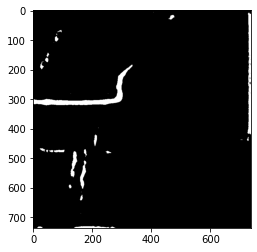

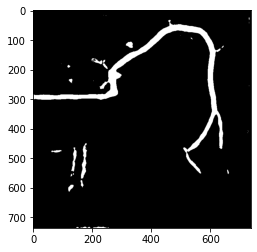

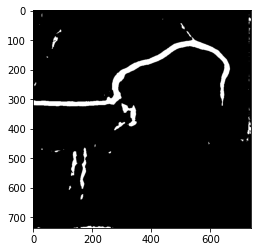

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from natsort import natsorted

path_to_grey_img = r"greyscale"
path_to_grey_seg = r"greyscale_out"

val_samples = 10
random.seed(1234)
val_idx = random.sample(range(0,len(segs)),val_samples) 
val_images = [images[idx] for idx in val_idx]
val_masks =   [segs[idx] for idx in val_idx]
val_files = [{"img": img, "seg": seg}
              for img, seg in zip(val_images, val_masks)]

val_transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            AddChanneld(keys=["img", "seg"]),
            ScaleIntensityd(keys=["img", "seg"]),
            EnsureTyped(keys=["img", "seg"]),
        ]
    )
post_trans = Compose([EnsureType(), Activations(
        sigmoid=True), AsDiscrete(threshold=0.5)])


# define dataset, data loader
val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1,
                          num_workers=0, collate_fn=list_data_collate)

test = iter(val_loader)
print(images[:4])
print(segs[:4])


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for i, data in enumerate(test):
  img = data
  imshow(torchvision.utils.make_grid(list(img.values())[0]))
  imshow(torchvision.utils.make_grid(list(img.values())[1]))
  if (i == 3):
    break
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256), #16, 32, 64....
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load(
    "lr2_unet.pth"))
threshold = 0.5
model.eval()
val_iter = iter(val_loader)
for i, data in enumerate(val_iter):
  img = data
  output = model(list(img.values())[0])
  val_outputs = [post_trans(i) for i in decollate_batch(output)]
  plt.figure()
  plt.imshow((val_outputs[0][0]>threshold), cmap = "gray")
  #break

#plt.figure()
#plt.imshow((val_outputs[0][0]), cmap = "gray")

In [93]:
import torch

print(torch.cuda.is_available())

False
